<a href="https://colab.research.google.com/github/zd341/Author-Authentication/blob/main/Model_Testing_Authorship_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUTHORSHIP AUTHENTICATION

# BUSINESS UNDERSTANDING

The first aim is to chose the right dataset for this project
The second aim is to ???

**To Do**


*   Clean Twitter Dataset????
*   GridCV for all models.
*   Tidy Notebook.
*   Eliminate punction and gutenberg watermmarks from text.










### Configuring Google Drive and Checking GPU Collab Notebook

In [ ]:

# Check whether GPU is working
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# Check which GPU is available
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  

Found GPU at: /device:GPU:0
Tue Aug 31 06:38:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    36W / 250W |    345MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
# Access Google Drive

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgXoh8DRZUmoH0098xIiefMXdMc_jgPyjs16jGlnKjHZ8qSbZfuTjE


# DATA UNDERSTANDING PHASE- PHILOSOPHERS TEXT

### Loading In each of the books per Philosopher

In [ ]:

# Isolate Hume Corpus
with open('/content/drive/MyDrive/data/hume.txt', 'r', encoding='utf-8') as f:
  hume_corpus = f.read()
# Isolate Kant Corpus
with open('/content/drive/MyDrive/data/kant.txt', 'r', encoding='utf-8') as f:
  kant_corpus = f.read()
# Isolate Nietzsche Corpus
with open('/content/drive/MyDrive/data/nietzsche.txt', 'r', encoding='utf-8') as f:
  nietzsche_corpus = f.read()
# Isolate Aristotle Corpus
with open('/content/drive/MyDrive/data/aristotle.txt', 'r', encoding='utf-8') as f:
  aristotle_corpus = f.read()
# Isolate Plato Corpus
with open('/content/drive/MyDrive/data/plato.txt', 'r', encoding='utf-8') as f:
  plato_corpus = f.read()



### Checking the first 50 lines of each book

In [ ]:

# Print 50 lines from each book 

print(hume_corpus[0:50])
print(kant_corpus[0:50])
print(nietzsche_corpus[0:50])
print(aristotle_corpus[0:50])
print(plato_corpus[0:50])


﻿THE victory which the earl of Richmond gained at 
﻿We may call the faculty of cognition from princip
﻿What I am now going to relate is the history of t
﻿Things are said to be named 'equivocally' when, t
﻿SOCRATES: My dear Phaedrus, whence come you, and 


In [ ]:

# test = hume_corpus.split(sep=".")



### Checking the Length of Each Corpus

In [ ]:

print(f"The length of the Aristotle corpus is: {str(len(aristotle_corpus))}")
print(f"The length of the Hume corpus is: {str(len(hume_corpus))}")
print(f"The length of the Kant corpus is: {str(len(kant_corpus))}")
print(f"The length of the Plato corpus is: {str(len(plato_corpus))}")


The length of the Aristotle corpus is: 2094656
The length of the Hume corpus is: 10247796
The length of the Kant corpus is: 3176605
The length of the Plato corpus is: 3437247


## Load Text Processing Libraries

In [ ]:

# Load necessary natural language processing libraries
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)
import re
import string
sw = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Define Cleaner Functions for Unstructured Texts

In [ ]:

# First text cleaner

def text_cleaner(string):
  string = re.sub("Part","",string)
  string = string.lower()
  return re.sub("\n"," ",string)

# Lemmatize Cleaning of text

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# General Cleaning of text


def clean_up(text):
    text = text.replace(' ', ' ')
    text = text.replace('–', '-')
    text = text.replace('\n', ' ')
    text = re.sub(r'[IVXLCDM]+\.', '', text)
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r':', '', text)
    text = re.sub(r'\((.*?)\)', '', text)
    text = re.sub(r'\{(.*?)\}', '', text)
    text = re.sub(r'\b[A-Z]{2,}\b', '', text)
    text = text.replace(' ,', ',')
    text = text.replace(' .', '.')
    text = text.replace(' ;', ';')
    text = re.sub(r'[^A-Za-z0-9äÄöÖüÜß\s\.\-\!\?\:\;\,]', '', text)
    text = re.sub(r' +', ' ', text)
    return text

# Remove punctuation

def remove_punct(text):
  table = str.maketrans("","", string.punctuation)
  return text.translate(table)

# Removing stopwords

def remove_stop_words(text):
  text = [word.lower() for word in text.split() if word.lower() not in sw ]

  return " ".join(text)


# df_stratified['sentence'] =   df_stratified['sentence'].map(remove_stop_words)

# df_stratified.head()
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
# df_n['sentence']= df)n.sentence.map(lambda x: remove_punct(x))
# philo['sentence'] = philo.sentence.map(lemmatize_words)
# df_stratified['sentence'] =   df_stratified['sentence'].map(remove_stop_words)


# def remove_stop_words(text):
#   text = [word.lower() for word in text.split() if word.lower() not in sw ]

#   return " ".join(text)


## Clean Corpus For Each Author

In [ ]:

# 1. Cleaning Kant Text

kant_corpus = clean_up(kant_corpus)

kant_corpus = remove_stop_words(kant_corpus)

kant_corpus = lemmatize_words(kant_corpus)

kant_corpus = remove_punct(kant_corpus)


# 2. Cleaning Aristotle Text

aristotle_corpus = clean_up(aristotle_corpus) 

aristotle_corpus = remove_stop_words(aristotle_corpus)

aristotle_corpus = lemmatize_words(aristotle_corpus)

aristotle_corpus = remove_punct(aristotle_corpus)

# 3. Cleaning Hume Text

hume_corpus = clean_up(hume_corpus) 

hume_corpus = remove_stop_words(hume_corpus) 

hume_corpus = lemmatize_words(hume_corpus) 

hume_corpus = remove_punct(hume_corpus) 

# 4. Cleaning Plato Text

plato_corpus = clean_up(plato_corpus) 

plato_corpus = remove_stop_words(plato_corpus) 

plato_corpus = lemmatize_words(plato_corpus) 

plato_corpus = remove_punct(plato_corpus)

# 5. Cleaning Nietzsche Text

nietzsche_corpus = clean_up(nietzsche_corpus) 

nietzsche_corpus = remove_stop_words(nietzsche_corpus) 

nietzsche_corpus = lemmatize_words(nietzsche_corpus) 

nietzsche_corpus = remove_punct(nietzsche_corpus)


### Tokenizing Corpus Into Words and Sentences

In [ ]:

# Importing Tokenizing Libraries 

from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
# nltk.download('punkt')

#1. Generate sentences and tokens for aristotle_corpus
aristotle_sents = sent_tokenize(aristotle_corpus,language='english')
aristotle_tokens = word_tokenize(aristotle_corpus,language='english')

#2. Generate sentences and tokens for hume
# hume_sents = sent_tokenize(hume_corpus,language='english')
hume_sents = hume_corpus.split(sep=".")
hume_tokens = word_tokenize(hume_corpus,language='english')

#3. Generate sentences and tokens for nietzsche
nietzsche_sents = sent_tokenize(nietzsche_corpus,language='english')
nietzsche_tokens = word_tokenize(nietzsche_corpus,language='english')

#4. Generate sentences and tokens for kant
kant_sents = sent_tokenize(kant_corpus,language='english')
kant_tokens = word_tokenize(kant_corpus,language='english')

#5. Generate sentences and tokens for plato
plato_sents = sent_tokenize(plato_corpus,language='english')
plato_tokens = word_tokenize(plato_corpus,language='english')



## Generate Dataframe

In [ ]:

# Create Data Frames for each set of sentences
import pandas as pd
aris = pd.DataFrame({'label':0, 'author':'Aristotle','sentence': aristotle_sents})
niet = pd.DataFrame({'label':1, 'author':'Nietzsche','sentence': nietzsche_sents})
kant = pd.DataFrame({'label':2,'author':'Kant','sentence':kant_sents})
Plat = pd.DataFrame({'label':3,'author':'Plato','sentence':plato_sents})
Hum  = pd.DataFrame({'label':4,'author':'Hume','sentence':hume_sents})
# Make a list of lists
frames = [aris,niet,kant,Plat,Hum]
# Concatenante frames into a single dataframe
philo = pd.concat(frames)

philo.head()


,label,author,sentence
0,0,Aristotle,"thing said named equivocally when, though comm..."
1,0,Aristotle,"thus, real man figure picture lay claim name a..."
2,0,Aristotle,"one define sense animal, definition one case a..."
3,0,Aristotle,"hand, thing said named univocally name definit..."
4,0,Aristotle,"man ox animal, univocally named, inasmuch name..."


### Removing Short Sentences

In [ ]:

philo['sent_len'] = philo['sentence'].apply(lambda x: len(x))
philo = philo.drop(philo[philo['sent_len'] < 20].index)
len(philo)


63386

### Removing Contractions


### Get Unique Tokens For Each

In [ ]:


#1. Generate the unique tokens for aristotle
aristotle_unique_words = []
for token in aristotle_tokens:
  if token not in aristotle_unique_words:
    aristotle_unique_words.append(token)
    
#2. Generate the unique tokens for kant
kant_unique_words = []
for token in kant_tokens:
  if token not in kant_unique_words:
    kant_unique_words.append(token)

#3. Generate the unique tokens for hume

hume_unique_words = []
for token in hume_tokens:
  if token not in hume_unique_words:
    hume_unique_words.append(token)


#4. Generate the unique tokens for plato

plato_unique_words = []
for token in plato_tokens:
  if token not in plato_unique_words:
    plato_unique_words.append(token)


#5. Generate the unique tokens for nietzsche

nietzsche_unique_words = []
for token in nietzsche_tokens:
  if token not in nietzsche_unique_words:
    nietzsche_unique_words.append(token)


### Generate Part-of-Speech Tags for each Author


In [ ]:
pos_tagging_enabled =  False

if pos_tagging_enabled == True:
  pos_tags = {'ADJ':'adjective', 'ADV':'adverb', 'ADP':'adposition', 
              'AUX':'auxiliary', 'DET':'determiner', 'NUM':'numeral', 
              'X':'other', 'INTJ':'interjection', 'CONJ':'conjunction', 
              'CCONJ':'coord. conjunction', 'SCONJ':'subord. conjunction', 
              'PROPN':'proper noun', 'NOUN':'noun', 'PRON':'pronoun', 
              'PART':'particle', 'VERB':'verb'}
            
  for tag in list(pos_tags.keys()):
    philo[f'{tag}_count'] = philo['sentence'].apply(lambda sen: pos_count(sen, tag))

In [ ]:
philo.head()

,label,author,sentence,sent_len
0,0,Aristotle,thing said named equivocally when though commo...,1154923
0,1,Nietzsche,going relate history next two centuries shall ...,2042991
0,2,Kant,may call faculty cognition principle priori pu...,1891229
0,3,Plato,dear phaedrus whence come you whither going co...,1860682
0,4,Hume,victory earl richmond gained bosworth entirely...,6113368


In [ ]:
plato_corpus

'dear phaedrus whence come you whither going come lysias son cephalus going take walk outside wall sitting whole morning common friend acumenus tell much refreshing walk open air shut cloister right lysias then suppose town yes staying epicrates house morychus house near temple olympian zeus entertain you wrong supposing lysias gave feast discourse shall hear spare time accompany me deem conversation lysias thing higher import may say word pindar business go on go narration tale socrates one sort love theme occupied uslove fashion lysias writing fair youth tempted lover point ingeniously proved nonlover accepted rather lover noble him wish would say poor man rather rich old man rather young onethen would meet case many man word would quite refreshing would public benefactor part long hear speech walk way megara reached wall come back herodicus recommends without going in keep company mean good socrates imagine unpractised memory justice elaborate work greatest rhetorician age spent lon

## Importing and Checking Data

In [ ]:

import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/data/sentences.csv')


In [ ]:

df.head(3)


,label,sentence,author,word_count,mean_word_length,stop_words_ratio,stop_words_count,ADJ_count,ADV_count,ADP_count,AUX_count,DET_count,NUM_count,X_count,INTJ_count,CONJ_count,CCONJ_count,SCONJ_count,PROPN_count,NOUN_count,PRON_count,PART_count,VERB_count
0,0,We may call the faculty of cognition from prin...,Kant,64,5.20,56.25,36,6,2,11,0,11,0,1,0,0,2,3,0,17,3,1,7
1,0,That goes merely into our faculty of knowing t...,Kant,82,5.13,57.32,47,5,4,14,1,14,0,3,0,0,6,2,3,17,4,0,9
2,0,"The Critique, then, which sifts them all, as r...",Kant,50,4.84,62.00,31,4,1,6,1,12,0,1,0,0,1,3,1,10,3,1,6


In [ ]:

df_n = df.iloc[:,:3]

df_n.head()


,label,sentence,author
0,0,We may call the faculty of cognition from prin...,Kant
1,0,That goes merely into our faculty of knowing t...,Kant
2,0,"The Critique, then, which sifts them all, as r...",Kant
3,0,It relegates all other pure concepts under Ide...,Kant
4,0,For they serve as regulative principles; partl...,Kant


In [ ]:

print(df['label'].unique())

print(df['author'].unique())

philo_list = ['Kant', 'Hume', 'Plato', 'Aristotle','Nietzsche']


[0 1 2 3 4]
['Kant' 'Hume' 'Plato' 'Aristotle' 'Nietzsche']


In [ ]:

df_n.shape


(107134, 3)

# DATA PREPARATION PHASE - PHILOSOPHERS TEXT

## Data Quality Check and Cleaning

In [ ]:

# Import Natural Language Processing Libraries
import nltk
import re
import string
import spacy

nlp = spacy.load('en_core_web_sm')


### Checking For Missing Data

In [ ]:

df_n.isnull().sum()


label       0
sentence    0
author      0
dtype: int64

In [12]:

sent = df_n['sentence'][0]

sent


'We may call the faculty of cognition from principles a priori, pure Reason, and the inquiry into its possibility and bounds generally the Critique of pure Reason, although by this faculty we only understand Reason in its theoretical employment, as it appears under that name in the former work; without wishing to inquire into its faculty, as practical Reason, according to its special principles.'

### Abbreviating Author Name

In [13]:

df_n['abrev_auth']= df_n['author'].apply(lambda abrev: 'KNT' if abrev == 'Kant' 
                                         else 'HUM' if abrev == 'Hume' 
                                         else 'PLT' if abrev == 'Plato' 
                                         else 'ALE' if abrev =='Aristotle' 
                                         else 'NZE')


df_n["abrev_auth"].unique()


array(['KNT', 'HUM', 'PLT', 'ALE', 'NZE'], dtype=object)

### Removing Capitalisation

In [14]:

# Remove all Capitalisation

df_n['lower_sentence']= df_n['sentence'].apply(lambda s: s.lower())

df_n['lower_sentence'][0]


'we may call the faculty of cognition from principles a priori, pure reason, and the inquiry into its possibility and bounds generally the critique of pure reason, although by this faculty we only understand reason in its theoretical employment, as it appears under that name in the former work; without wishing to inquire into its faculty, as practical reason, according to its special principles.'

### Re-ordering Columns

In [15]:

df_n["abrev_auth"].unique()

# Deleting the author column
# del df_n['author'] 

# Re-ordering columns in dataframe
df_n = df_n[["label", "abrev_auth", "sentence","lower_sentence"]]

# Rename Columns
df_n.rename(inplace=True,columns={"abrev_auth":"author"})


### Re-naming Columns

In [16]:

del df_n['sentence']


df_n.rename(inplace=True,columns={"lower_sentence":"sentence"})


In [17]:

df_n.head()


,label,author,sentence
0,0,KNT,we may call the faculty of cognition from prin...
1,0,KNT,that goes merely into our faculty of knowing t...
2,0,KNT,"the critique, then, which sifts them all, as r..."
3,0,KNT,it relegates all other pure concepts under ide...
4,0,KNT,for they serve as regulative principles; partl...


### Cleaning Semi-colon, writing idosyncrasies in Texts

In [20]:

df_n[df_n.author == 'PLT']


,label,author,sentence
58616,2,PLT,"my dear phaedrus, whence come you, and whithe..."
58617,2,PLT,"i come from lysias the son of cephalus, and i..."
58618,2,PLT,there he is right.
58619,2,PLT,"lysias then, i suppose, was in the town?"
58620,2,PLT,"yes, he was staying with epicrates, here at t..."
...,...,...,...
78352,2,PLT,"then if one is not, the others neither are, no..."
78353,2,PLT,nor as like or unlike?
78354,2,PLT,"nor as the same or different, nor in contact o..."
78355,2,PLT,then may we not sum up the argument in a word ...


In [19]:

# Creating a function that rids data of semi-colons and lowers strings
def semiCol_rm(string):
  n_string = re.sub(':','',string)
  n_string_r = re.sub('--','',n_string)
  n_string_r = n_string_r.lower()
  return n_string_r

# Applying Semi-colon function
df_n['sentence'] = df_n['sentence'].map(semiCol_rm)


# EXPLORATORY DATA ANALYSIS - PHILOSOPHERS TEXTS 

In [21]:

# Importing data visualisation Libraries 
import matplotlib.pyplot as plt 
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Seaborn Style
sns.set_theme(style="whitegrid")


In [22]:

# Creating an additional feature for character count.

df['CHAR_count'] = df['sentence'].apply(lambda x: len(x))



## Text Wrangling Before EDA

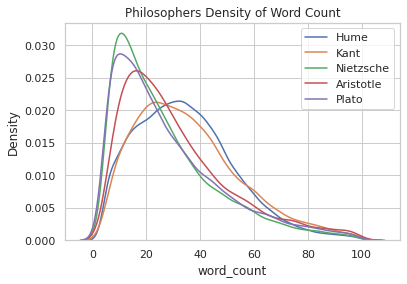

In [23]:

sns.kdeplot(df[df['author']=='Hume']['word_count'], alpha= 0.5,gridsize=200)
sns.kdeplot(df[df['author']=='Kant']['word_count'], alpha= 0.5)
sns.kdeplot(df[df['author']=='Nietzsche']['word_count'], alpha= 0.5)
sns.kdeplot(df[df['author']=='Aristotle']['word_count'], alpha= 0.5)
sns.kdeplot(df[df['author']=='Plato']['word_count'], alpha= 0.5)
plt.legend(('Hume','Kant','Nietzsche','Aristotle','Plato'))
plt.title('Philosophers Density of Word Count')
plt.show()


### Philosopher Word Count Per Author

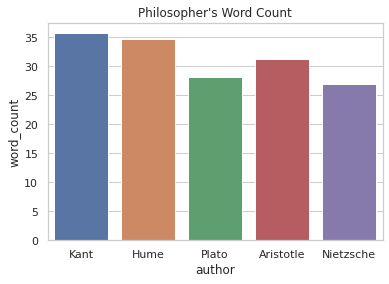

In [24]:

sns.barplot(data=df, x= df['author'],y=df['word_count'],ci=False)
plt.title("Philosopher's Word Count")
plt.show()


### Philosopher Characters per Sentence

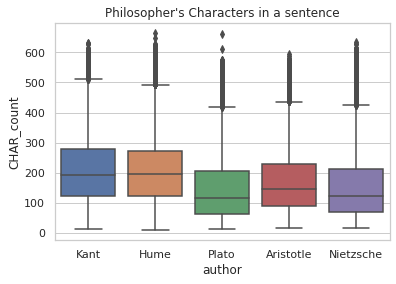

In [25]:
# sns.barplot(data = df, x= df['author'],y= df['CHAR_len'],ci=False)
# plt.title("Philosopher's Characters in a sentence")
# plt.show()


sns.boxplot(data= df, x='author',y='CHAR_count',)
plt.title("Philosopher's Characters in a sentence")
plt.show()

###  Philosopher Stop Word Ratio Comparison

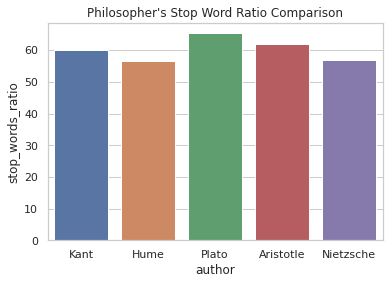

In [26]:

sns.barplot(data = df, x= df['author'],y= df['stop_words_ratio'],ci=False)
plt.title("Philosopher's Stop Word Ratio Comparison")
plt.show()


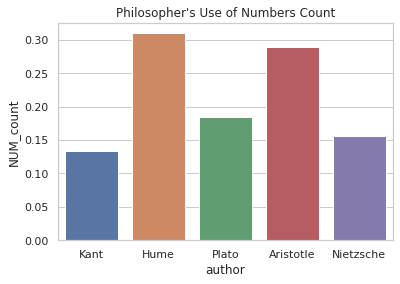

In [27]:

sns.barplot(data=df, x= df['author'],y=df['NUM_count'],ci=False)
plt.title("Philosopher's Use of Numbers Count")
plt.show()



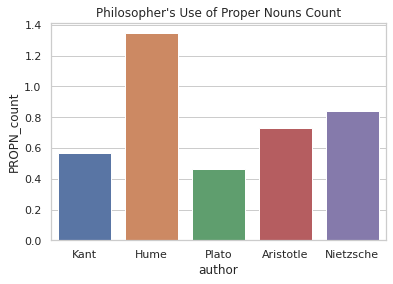

In [ ]:

sns.barplot(data=df, x= df['author'],y=df['PROPN_count'],ci=False)
plt.title("Philosopher's Use of Proper Nouns Count")
plt.show()


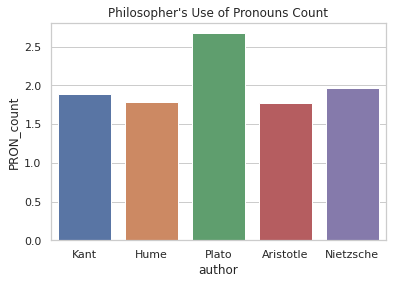

In [ ]:

sns.barplot(data=df, x= df['author'],y=df['PRON_count'],ci=False)
plt.title("Philosopher's Use of Pronouns Count")
plt.show()


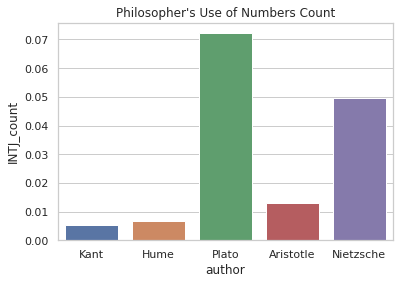

In [ ]:

sns.barplot(data=df, x= df['author'],y=df['INTJ_count'],ci=False)
plt.title("Philosopher's Use of Numbers Count")
plt.show()


##Bi-grams


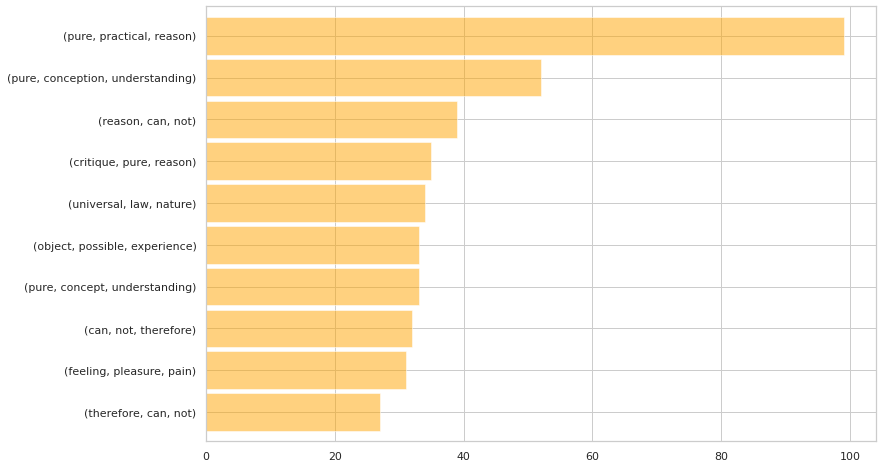

In [ ]:

bigram_series =(pd.Series(nltk.ngrams(kant_tokens, 3)).value_counts())[:10]

bigram_series.sort_values().plot.barh(color='orange',alpha=0.5 ,width=.9, figsize=(12, 8))


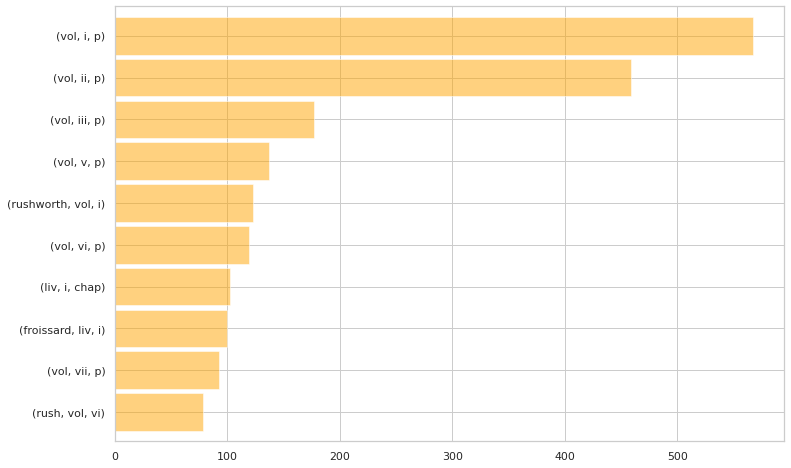

In [ ]:

bigram_series = pd.Series(nltk.ngrams(hume_tokens, 3)).value_counts()[:10]

bigram_series.sort_values().plot.barh(color='orange',alpha=0.5 ,width=.9, figsize=(12, 8))


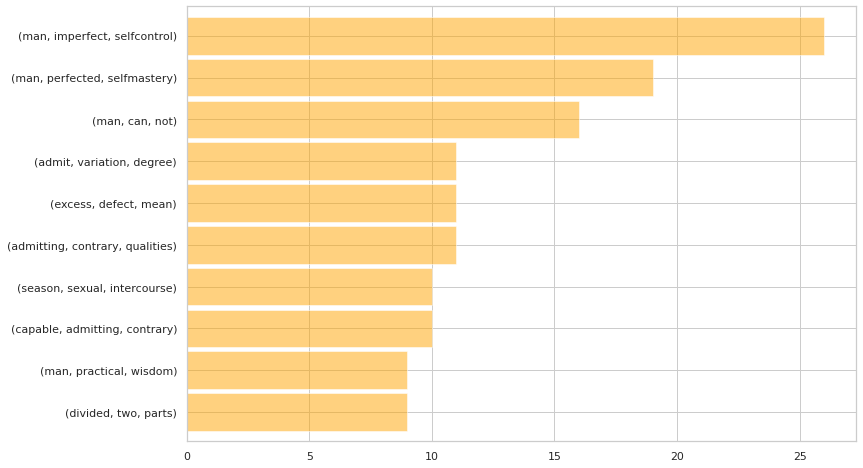

In [ ]:

bigram_series = pd.Series(nltk.ngrams(aristotle_tokens, 3)).value_counts()[:10]

bigram_series.sort_values().plot.barh(color='orange',alpha = 0.5 ,width=.9, figsize=(12, 8))


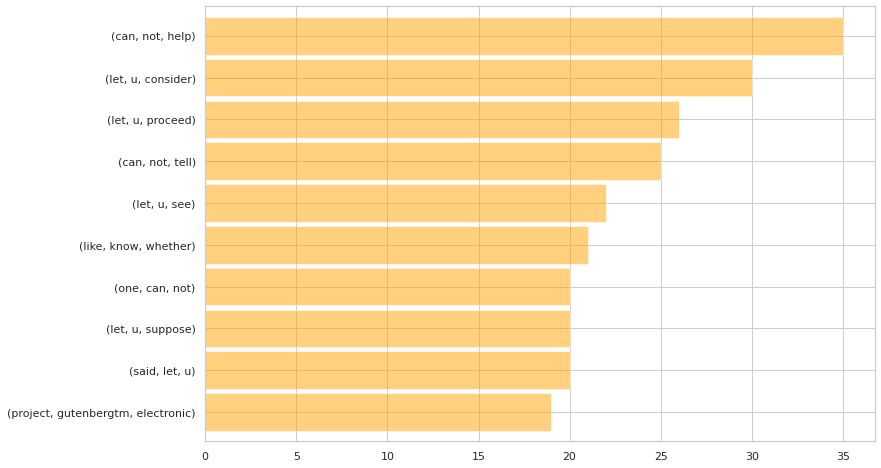

In [ ]:

bigram_series = pd.Series(nltk.ngrams(plato_tokens, 3)).value_counts()[:10]

bigram_series.sort_values().plot.barh(color='orange',alpha = 0.5 ,width=.9, figsize=(12, 8))


## Word Clouds

## Word Cloud- Aristotle

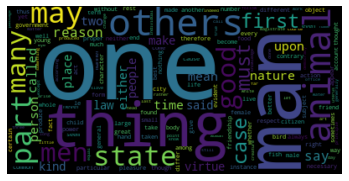

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(aristotle_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud- Kant


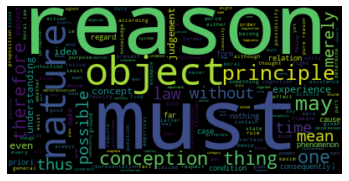

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(kant_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud- Nietzsche


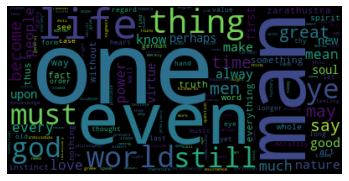

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(nietzsche_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud- Hume

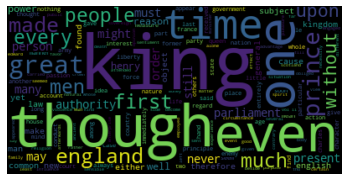

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(hume_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud- Plato

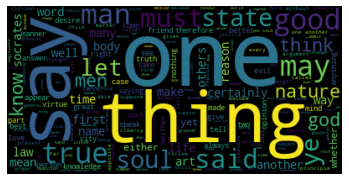

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(plato_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Frequency Distributions?

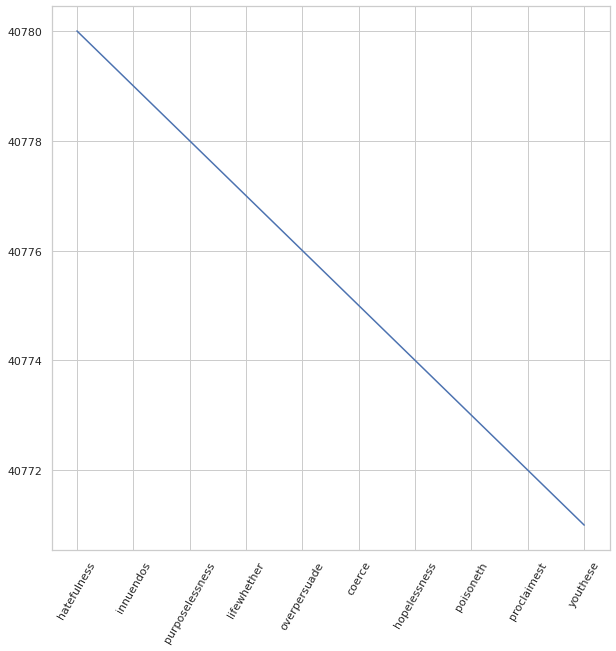

In [ ]:
# freqdist

all_fdist = nltk.FreqDist(word_index).most_common(10)

## Conversion to Pandas series for plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes and x-tick rotation
all_plot = sns.lineplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=60);


# Data Prep Before Modelling 

## Stratified Sampling

In [28]:
# Checking for class imbalances before machine learning
df_n['author'].value_counts()

HUM    45328
PLT    19741
NZE    18589
KNT    13288
ALE    10188
Name: author, dtype: int64

In [29]:
# Checking proportion of imbalance
(df_n['author'].value_counts() / len(df)).sort_values(ascending=False)

HUM    0.423096
PLT    0.184265
NZE    0.173512
KNT    0.124032
ALE    0.095096
Name: author, dtype: float64

In [30]:
# Function stratified sampling to  manage class imbalance

def stratify_data(df_data, stratify_col_name, stratify_val, stratify_prop, random_state=None):
    """
    Returns:
        DataFrame: a new dataframe based the new proportions represnting the desired stratification strategy
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty data frame with column names matching the dataframe your using

    pos = -1
    for i in range(len(stratify_val)): # iterate over the stratify values (e.g. "classes" etc.)
        pos += 1
        if pos == len(stratify_val) - 1: 
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration calculate the number of values in the last so the number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_prop[i]) # Calculate the number of rows to match the proportion 

        df_filtered = df_data[df_data[stratify_col_name] ==stratify_val[i]] # Filter the source data on the currently selected stratify values
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the stratified datasets together to produce the final result
        
    return df_stratified # Return the re-sampled data  
    

In [31]:

# Applying Stratified Sampling

stratify_values = ['KNT', 'HUM', 'PLT', 'ALE', 'NZE']
stratify_proportions = [0.20, 0.20, 0.20, 0.20,0.20]
df_stratified = stratify_data(df_n, 'author', stratify_values, stratify_proportions, random_state=42)


In [32]:

# Verfying sample's classes are proportionate

(df_stratified['author'].value_counts() / len(df)).sort_values(ascending=False)


NZE    0.200030
HUM    0.199993
KNT    0.199993
ALE    0.199993
PLT    0.199993
Name: author, dtype: float64

## MACHINE LEARNING MODELLING PHASE - PHILOSOPHERS TEXT 

## Sci-kit Learn

## Linear Support Vector Classifier

In [33]:

# Input Variables
X = df_stratified.sentence

# Output Variables
y= df_stratified.author


In [34]:

# Train Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [42]:

# Importing Feature Extraction models:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Importing Pipeline, models and cross-validation tools:

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


# Tfidf Pipeline 1:

svc_clf = Pipeline([('tfid',TfidfVectorizer()),('svc',LinearSVC(penalty='l2',C=0.5,max_iter=700))])

# # Count Vectorizer Pipeline 2:

svc_countvect_clf = Pipeline([('countvect',CountVectorizer(stop_words='english')),('svc',LinearSVC(penalty='l2',C=0.5,max_iter=500))])



In [44]:

%%time

svc_clf.fit(X_train,y_train)

svc_countvect_clf.fit(X_train,y_train)


CPU times: user 12.8 s, sys: 36.8 ms, total: 12.9 s
Wall time: 12.8 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [45]:

# predictions = svc_clf.predict(X_test)


predictions = svc_clf.predict(X_test)


predicitions_two = svc_countvect_clf.predict(X_test)



### Linear Support Vector Classifier Model Performance

In [46]:

# Import Metrics Packages
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,cohen_kappa_score
from sklearn import metrics


### SVC: CONFUSION MATRIX

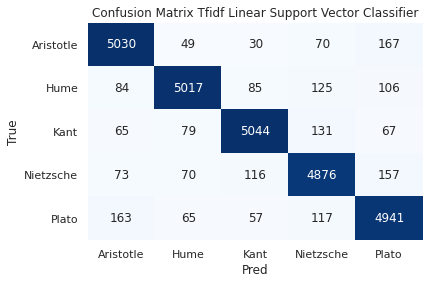

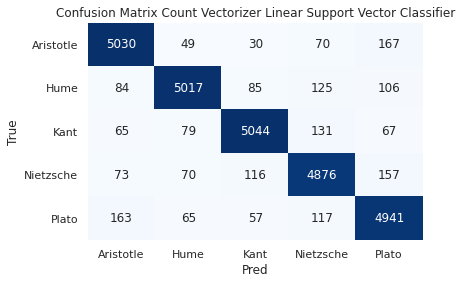

In [47]:

## Plot confusion matrix

classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Confusion Matrix Tfidf Linear Support Vector Classifier")
plt.yticks(rotation=0)
plt.show()


classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Confusion Matrix Count Vectorizer Linear Support Vector Classifier")
plt.yticks(rotation=0)
plt.show()



### SVC: Classification Report 

In [48]:

print("Tfidf Vectorizer Support Vector Classification Report")
print("\t")
print(classification_report(predictions,y_test))
print("\t")
print("\t")
print("Count Vectorizer Support Vector Classification Report")
print("\t")
print(classification_report(predicitions_two,y_test))


Tfidf Vectorizer Support Vector Classification Report
	
              precision    recall  f1-score   support

         ALE       0.94      0.93      0.93      5415
         HUM       0.93      0.95      0.94      5280
         KNT       0.94      0.95      0.94      5332
         NZE       0.92      0.92      0.92      5319
         PLT       0.92      0.91      0.92      5438

    accuracy                           0.93     26784
   macro avg       0.93      0.93      0.93     26784
weighted avg       0.93      0.93      0.93     26784

	
	
Count Vectorizer Support Vector Classification Report
	
              precision    recall  f1-score   support

         ALE       0.94      0.92      0.93      5443
         HUM       0.90      0.95      0.92      5183
         KNT       0.93      0.93      0.93      5386
         NZE       0.90      0.92      0.91      5144
         PLT       0.91      0.87      0.89      5628

    accuracy                           0.92     26784
   macro avg   

In [ ]:

print(f"Tfidf Support Vector Classifier Accuracy: {accuracy_score(predictions,y_test)}")

print(f"Tfidf Support Vector Classifier Kappa Score: {cohen_kappa_score(predictions,y_test)}")

print("\t")
print("\t")

print(f"Count Vectorizer Support Vector Classifier Accuracy: {accuracy_score(predicitions_two,y_test)}")

print(f"Count Vectorizer Support Vector Classifier Kappa Score: {cohen_kappa_score(predicitions_two,y_test)}")


Tfidf Support Vector Classifier Accuracy: 0.929958183990442
Tfidf Support Vector Classifier Kappa Score: 0.9124484389360791
	
	
Count Vectorizer Support Vector Classifier Accuracy: 0.9167786738351255
Count Vectorizer Support Vector Classifier Kappa Score: 0.895973431872895


# SUPPORT VECTOR CLASSIFIER: MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## Support Vector Classifier: GridSearchCV

In [ ]:

from sklearn.model_selection import GridSearchCV

# Tuning hyper parameters forr Linear svc classifier 


## Naive Bayes Multinomial Classifer NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Pipeline 1- tdif:
nb_clf = Pipeline([('tdif',TfidfVectorizer()),
                   ('naivebaiyes',MultinomialNB(alpha=0.1,
                    class_prior=None ,fit_prior=True))])

# Pipeline 2- Count Vect:
count_nb_clf = Pipeline([('countvect',CountVectorizer(stop_words='english')),
                   ('naivebaiyes',MultinomialNB(alpha=0.1,
                    class_prior=None ,fit_prior=True))])

In [ ]:

%%time 
# Fit Tfidf Model
nb_clf.fit(X_train,y_train)

# Fit Count Vectorizer Model
count_nb_clf.fit(X_train,y_train)


CPU times: user 3.85 s, sys: 20.5 ms, total: 3.88 s
Wall time: 3.86 s


In [ ]:

# Using Tfidf to predict test set
pred = nb_clf.predict(X_test)

# Using Count Vectorizer to predict test set
pred_2 = count_nb_clf.predict(X_test)


### Multinomial NB Model Performance

In [ ]:


print(f"Tfidf Multinomial NB Classifier Accuracy: {accuracy_score(pred,y_test)}")
print(f"Tfidf Multinomial NB Classifier Kappa Score: {cohen_kappa_score(pred,y_test)}")
print("\t")
print("\t")
print(f"Count Vectorizer Multinomial NB Classifier Accuracy: {accuracy_score(pred_2,y_test)}")
print(f"Count Vectorizer Multinomial NB Classifer Kappa Score: {cohen_kappa_score(pred_2,y_test)}")


Tfidf Multinomial NB Classifier Accuracy: 0.8909423536439666
Tfidf Multinomial NB Classifier Kappa Score: 0.8636737074572655
	
	
Count Vectorizer Multinomial NB Classifier Accuracy: 0.8743279569892473
Count Vectorizer Multinomial NB Classifer Kappa Score: 0.8429071247264379


### MultinomialNB: Confusion Matrix

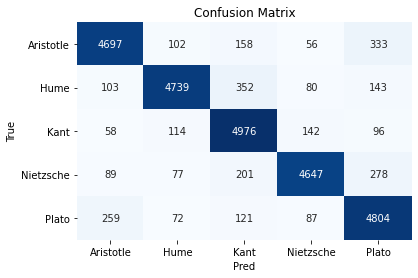

In [ ]:

# MultinomialNB Confusion Matrix
classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### MultinomialNB: Classification Report 

In [ ]:

print("Tfidf Multinomial NB Classification Report")
print("\t")
print(classification_report(pred,y_test))
print("\t")
print("\t")
print("Count Vectorizer Multinomial NB Classification Report")
print("\t")
print(classification_report(pred_2,y_test))


Tfidf Multinomial NB Classification Report
	
              precision    recall  f1-score   support

         ALE       0.88      0.90      0.89      5206
         HUM       0.87      0.93      0.90      5104
         KNT       0.92      0.86      0.89      5808
         NZE       0.88      0.93      0.90      5012
         PLT       0.90      0.85      0.87      5654

    accuracy                           0.89     26784
   macro avg       0.89      0.89      0.89     26784
weighted avg       0.89      0.89      0.89     26784

	
	
Count Vectorizer Multinomial NB Classification Report
	
              precision    recall  f1-score   support

         ALE       0.86      0.89      0.88      5202
         HUM       0.87      0.91      0.89      5200
         KNT       0.90      0.85      0.88      5690
         NZE       0.87      0.89      0.88      5199
         PLT       0.86      0.84      0.85      5493

    accuracy                           0.87     26784
   macro avg       0.87   

# NAIVE BAYES: MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## Naives Bayes: GridSearchCV

In [ ]:
param_grid = {'alpha': [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid = GridSearchCV(MultinomialNB(),param_grid,refit=True,verbose=2,cv=5)

tfid = TfidfVectorizer()
tfid_X_train = tfid.fit_transform(X_train)

tfid_X_test = tfid.fit_transform(X_test)

grid.fit(tfid_X_train,y_train)

print("Best Estimator: ",grid.best_estimator_)
print("Best Score: ", grid.best_score_)

## XGBoost & RandomForest Model

In [ ]:

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# xgb_clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

tdif_xgb_clf = Pipeline([('tdif',TfidfVectorizer()),
                   ('XGBoost',XGBClassifier())]) #random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7

count_vect_xgb_clf = Pipeline([('countvect',CountVectorizer(stop_words='english')),
                   ('XGBoost',XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7))])

rf_clf = Pipeline([('tdif',TfidfVectorizer()),('rf',RandomForestClassifier())])


In [ ]:
%%time

# training tfidf xgboost model
tdif_xgb_clf.fit(X_train,y_train)
# training count vectorizer xgboost model
count_vect_xgb_clf.fit(X_train,y_train)
# training tfidf Randomforest model
rf_clf.fit(X_train,y_train)


CPU times: user 6min 45s, sys: 777 ms, total: 6min 46s
Wall time: 6min 44s


In [ ]:

# Predicting Values for both models
predictions = tdif_xgb_clf.predict(X_test)

predictions_two = count_vect_xgb_clf.predict(X_test)

predictions_rf = rf_clf.predict(X_test)


### XGBoost Classifier Model Performance

In [ ]:

# Model and Kappa Score

print(f"Tfidf XGBoost Classifier Accuracy: {accuracy_score(predictions,y_test)}")
print(f"Tfidf XGBoost Classifier Kappa Score: {cohen_kappa_score(predictions,y_test)}")
print("\t")
print("\t")
print(f"Count Vectorizer XGBoost Classifier Accuracy: {accuracy_score(predictions_two,y_test)}")
print(f"Count Vectorizer XGBoost Classifer Kappa Score: {cohen_kappa_score(predictions_two,y_test)}")
print("\t")
print("\t")
print(f"Tfidf Vectorizer RandomForest Classifier Accuracy: {accuracy_score(predictions_rf,y_test)}")
print(f"Tfidf Vectorizer RandomForest Classifier Kappa Score: {cohen_kappa_score(predictions_rf,y_test)}")


Tfidf XGBoost Classifier Accuracy: 0.6664799880525687
Tfidf XGBoost Classifier Kappa Score: 0.583162712778982
	
	
Count Vectorizer XGBoost Classifier Accuracy: 0.6111857825567503
Count Vectorizer XGBoost Classifer Kappa Score: 0.5142770486401265
	
	
Tfidf Vectorizer RandomForest Classifier Accuracy: 0.8991935483870968
Tfidf Vectorizer RandomForest Classifier Kappa Score: 0.8739933626656148


### XGBoost & RandomForest: Confusion Matrix

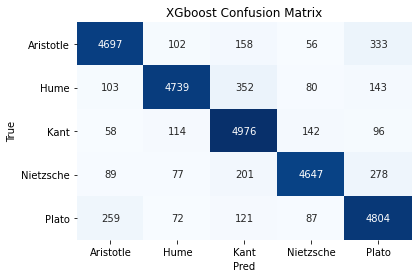

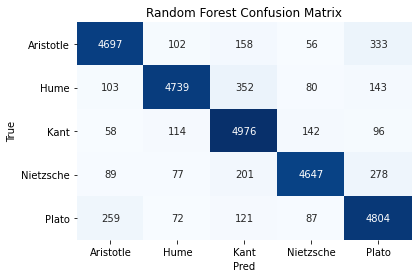

In [ ]:

confusion_matrix(predictions,y_test)

# XGboost Classifier Confusion Matrix
classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="XGboost Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


confusion_matrix(predictions_rf,y_test)

# Random Forest Classifier Confusion Matrix
classes = np.unique(philo_list)
cm = metrics.confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels=classes,yticklabels=classes
       ,title="Random Forest Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### XGBoost & RandomForest: Classificaion Report

In [ ]:

print("Tfidf XGBoost Classification Report")
print(classification_report(predictions,y_test))
print("\t")
print("Countvector XGBoost Classification Report")
print(classification_report(predictions_two,y_test))
print("\t")
print("Tfidf Random Forest Classifier Classification Report")
print(classification_report(predictions_rf,y_test))



Tfidf XGBoost Classification Report
              precision    recall  f1-score   support

         ALE       0.65      0.62      0.64      5662
         HUM       0.65      0.71      0.68      4992
         KNT       0.69      0.78      0.73      4777
         NZE       0.64      0.56      0.60      6050
         PLT       0.69      0.70      0.69      5303

    accuracy                           0.67     26784
   macro avg       0.67      0.67      0.67     26784
weighted avg       0.67      0.67      0.66     26784

	
Countvector XGBoost Classification Report
              precision    recall  f1-score   support

         ALE       0.51      0.65      0.57      4175
         HUM       0.56      0.82      0.67      3684
         KNT       0.68      0.77      0.72      4774
         NZE       0.73      0.42      0.54      9199
         PLT       0.57      0.61      0.59      4952

    accuracy                           0.61     26784
   macro avg       0.61      0.66      0.62     267

# XGBOOST & RANDOMFOREST CLASSIFIER: MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## XGBoost Classifier: GridSearchCV

# MACHINE MODELLING EVALUATION PHASE - PHILOSOPHERS TEXT

## Hyperparameter Tuning GRIDCV 

In [ ]:


# grid = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=2,cv=5)



# grid.fit(tfid_X_train,y_train)


In [ ]:
# print(grid.best_estimator_)

# DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving models

In [ ]:

from sklearn.externals import joblib
sv = 'svc_clf.sav' 
mb = 'multinb_clf.sav'
xgb = 'xbg_clf.csv'
rf = 'rf_clf.csv'

joblib.dump('svc_clf',sv)
joblib.dump('multinb_clf',mb)
joblib.dump('xgb_clf',xgb)
joblib.dump('rf_clf',rf)

['rf_clf.csv']

# NEURAL NETWORK MODELLING PHASE - PHILOSOPHERS TEXT 

## Deep Learning with **Keras**


## NEURAL NETWORK MODEL DATA PRE-PROCESSING

In [ ]:

# Importing Layers, Sequential Model, Feature Extraction, Text Pre-processing, Tokenizer
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import utils 


from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping



In [ ]:
 
 # Split between variables into input and target variable
 X = df_stratified.sentence

 y = df_stratified.label
 

In [ ]:
from tensorflow import keras

labels = keras.utils.to_categorical(y,num_classes=5)


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras import utils 

n_most_common_words = 40000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values) 
sequences = tokenizer.texts_to_sequences(X.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 40780 unique tokens.


In [ ]:
word_index

## LSTM ARCHITECTURE & TRAINING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)


In [ ]:
epochs = 15
emb_dim = 128
batch_size = 256
vocab = len(word_index) + 1

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# Model layers
lstm_model = Sequential()
lstm_model.add(Embedding(vocab, emb_dim, input_length=X.shape[1]))
# model.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
lstm_model.add(SpatialDropout1D(0.7)) ## different dropout options = 0.2, 0.8, 0.7
lstm_model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
lstm_model.add(Dense(5, activation='softmax'))

# Model Compiler
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Model Summary
print(lstm_model.summary())


((80350, 130), (80350, 5), (26784, 130), (26784, 5))
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 128)          5219968   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 5,269,701
Trainable params: 5,269,701
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

%%time 
history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=256,validation_split=0.2
                    ,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)],shuffle=True) #batch_size 37, 256, 300


Epoch 1/15
252/252 [==============================] - 97s 373ms/step - loss: 1.2233 - acc: 0.4863 - val_loss: 0.7133 - val_acc: 0.7485
Epoch 2/15
252/252 [==============================] - 94s 373ms/step - loss: 0.7178 - acc: 0.7398 - val_loss: 0.4581 - val_acc: 0.8432
Epoch 3/15
252/252 [==============================] - 94s 373ms/step - loss: 0.5423 - acc: 0.8086 - val_loss: 0.3879 - val_acc: 0.8717
Epoch 4/15
252/252 [==============================] - 94s 374ms/step - loss: 0.4530 - acc: 0.8424 - val_loss: 0.3308 - val_acc: 0.8888
Epoch 5/15
252/252 [==============================] - 94s 374ms/step - loss: 0.3850 - acc: 0.8674 - val_loss: 0.3126 - val_acc: 0.8959
Epoch 6/15
252/252 [==============================] - 94s 373ms/step - loss: 0.3415 - acc: 0.8821 - val_loss: 0.2915 - val_acc: 0.9011
Epoch 7/15
252/252 [==============================] - 94s 373ms/step - loss: 0.3031 - acc: 0.8973 - val_loss: 0.2833 - val_acc: 0.9062
Epoch 8/15
252/252 [==============================] - 9

# LSTM: EVALUATION PHASE - PHILOSOPHERS TEXT

## LSTM Model Evaluation





### LSTM model accuracy

In [ ]:

# Determining Accuracy of the LSTM model
accr = lstm_model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))


837/837 [==============================] - 24s 28ms/step - loss: 0.2546 - acc: 0.9242
Test set
  Loss: 0.2546
  Accuracy: 0.9242


### LSTM: Predictions and Model Metrics

In [ ]:

# Using LSTM to generate predictions on the test set
predictions = lstm_model.predict(x= X_test, batch_size = 10, verbose = 1) 


2679/2679 [==============================] - 70s 26ms/step


In [ ]:

# Rounding the predictions to generate the labels 
rounded_predictions = np.argmax(predictions,axis=-1)

# Making sure predictions are transformed into labels
rounded_predictions 

array([2, 1, 4, ..., 4, 2, 0])

### LSTM: Classification Report 

In [ ]:

# Importing metric libraries 
from sklearn.metrics import confusion_matrix,classification_report

# Turning the rounded predictions into a dataframe 
labels_pred = pd.DataFrame(rounded_predictions)
labels_pred.shape
y_test_sorted = np.argmax(y_test,axis=-1)

# Generate Confusion Matrix 
cm = confusion_matrix(y_true=y_test_sorted,y_pred=rounded_predictions)

# Generate and Print Classification Report 
classifcation_rep = (classification_report(y_test_sorted,rounded_predictions))
print("\n")
print(classifcation_rep)




              precision    recall  f1-score   support

           0       0.95      0.92      0.93      5386
           1       0.96      0.91      0.93      5417
           2       0.87      0.95      0.91      5343
           3       0.93      0.94      0.93      5346
           4       0.93      0.90      0.91      5292

    accuracy                           0.92     26784
   macro avg       0.93      0.92      0.92     26784
weighted avg       0.93      0.92      0.92     26784



### LSTM Confusion Matrix

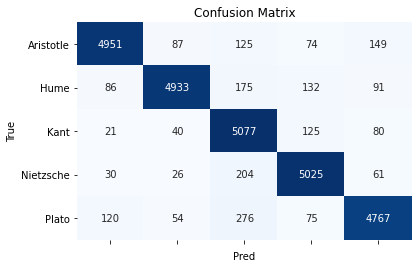

In [ ]:

# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### LSTM: Plotting Result to Compare training vs. Validation 

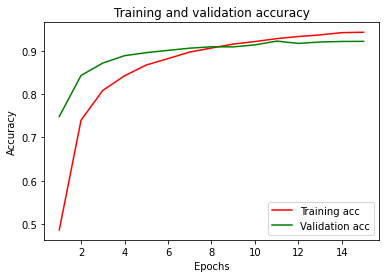

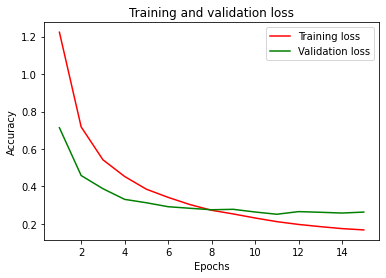

In [ ]:

# Comparing training and validation accuracy 

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### LSTM: Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score

print(cohen_kappa_score(y_test_sorted,rounded_predictions))

0.9052158445820354


### LSTM: Hyperparameter Tuning GRIDCV 

In [ ]:

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import rmsprop_v2

def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=130)) 
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(5, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [ ]:
import numpy as np
seed = 7
np.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/10
628/628 [==============================] - 2s 2ms/step - loss: 1.5246 - accuracy: 0.4218
Epoch 2/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4677 - accuracy: 0.4223
Epoch 3/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4632 - accuracy: 0.4223
Epoch 4/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4630 - accuracy: 0.4223
Epoch 5/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 6/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 7/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 8/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 9/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223
Epoch 10/10
628/628 [==============================] - 1s 2ms/step - loss: 1.4631 - accuracy: 0.4223

# DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving LSTM model

In [ ]:
# lstm_model.save("lstm_model.h5")
# load.model('/content/lstm_model.h5')

## **BI-LSTM MODEL**


In [ ]:

# Importing keras from tensorflow 
from tensorflow import keras
# from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
# Importing utilities from keras
from keras import utils
# Importing tokenizers, sequences and padding for text wrangling
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
# Importing Sequences, early stopping to instantiate and moderate overfitting
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# Imlaypers required for Neural network model architecture
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D


## BI-LSTM DATA PRE-PROCESSING

In [ ]:

# Creating input and output variables
sentences = df_n.sentence
labels = df_n.label


In [ ]:

# Importing and fitting tokenizer
from keras.preprocessing.text import Tokenizer
max_words = 40000
max_len = 130
tokenize = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenize.fit_on_texts(sentences.values)
# Converting texts to sequences then into a word index
sequences = tokenize.texts_to_sequences(sentences.values)
word_index = tokenize.word_index
print(len(word_index))
# Pading texts to limit the word count
X = pad_sequences(sequences,maxlen=max_len)
y = keras.utils.to_categorical(labels.values,num_classes=5)



In [ ]:

# splitting training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.25, random_state=42)


In [ ]:

# Defining the number of epochs, embedding dimensions, batch size and vocab length required in the model
epochs = 15
emb_dim = 130
batch_size = 256
vocab = len(word_index) + 1


In [ ]:

# Checking that training and test set are the same input dims
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((80350, 130), (80350, 5), (26784, 130), (26784, 5))


## BI-LSTM MODEL ARCHITECTURE & TRAINING

### BI-LSTM MODEL ARCHITECTURE 1

In [ ]:

# Model Architecture 1

bi_lstm_model1= Sequential()

bi_lstm_model1.add(Embedding(vocab,emb_dim))
# model.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
bi_lstm_model1.add(Dropout(0.5)) # (0.5 ,0.8) was the previous more hardline dropout 
bi_lstm_model1.add(Bidirectional(LSTM(emb_dim)))#emb_dim
bi_lstm_model1.add(Dense(5,activation='softmax'))

bi_lstm_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bi_lstm_model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 130)         5301530   
_________________________________________________________________
dropout (Dropout)            (None, None, 130)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 260)               271440    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1305      
Total params: 5,574,275
Trainable params: 5,574,275
Non-trainable params: 0
_________________________________________________________________


### BI-LSTM MODEL ARCHITECTURE 2

In [ ]:

# Model Architecture 2

model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(vocab,emb_dim))
# model_bi_lstm.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
model_bi_lstm.add(SpatialDropout1D(0.3))
model_bi_lstm.add(Bidirectional(LSTM(emb_dim, dropout=0.3, recurrent_dropout=0.3)))
model_bi_lstm.add(Dense(emb_dim, activation='relu'))
model_bi_lstm.add(Dropout(0.8))
model_bi_lstm.add(Dense(emb_dim, activation='relu')) # relu, tanh sigmoid
model_bi_lstm.add(Dropout(0.8))
model_bi_lstm.add(Dense(5,activation='softmax'))
model_bi_lstm.summary()
model_bi_lstm.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) # adam > RMSprop


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, None, 130)         4865510   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 130)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260)               271440    
_________________________________________________________________
dense_48 (Dense)             (None, 130)               33930     
_________________________________________________________________
dropout_42 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 130)               17030     
_________________________________________________________________
dropout_43 (Dropout)         (None, 130)             

In [ ]:
%%time
epoch = 15

history = bi_lstm_model1.fit(X_train, y_train, epochs=epoch, batch_size=128,validation_split=0.2
                    ,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


Epoch 1/15
503/503 [==============================] - 20s 32ms/step - loss: 0.7258 - accuracy: 0.7221 - val_loss: 0.3581 - val_accuracy: 0.8785
Epoch 2/15
503/503 [==============================] - 15s 31ms/step - loss: 0.2713 - accuracy: 0.9107 - val_loss: 0.2734 - val_accuracy: 0.9095
Epoch 3/15
503/503 [==============================] - 15s 31ms/step - loss: 0.1743 - accuracy: 0.9422 - val_loss: 0.2647 - val_accuracy: 0.9175
Epoch 4/15
503/503 [==============================] - 15s 31ms/step - loss: 0.1324 - accuracy: 0.9570 - val_loss: 0.2708 - val_accuracy: 0.9210
Epoch 5/15
503/503 [==============================] - 15s 31ms/step - loss: 0.1059 - accuracy: 0.9657 - val_loss: 0.2736 - val_accuracy: 0.9233
Epoch 6/15
503/503 [==============================] - 15s 31ms/step - loss: 0.0893 - accuracy: 0.9709 - val_loss: 0.3098 - val_accuracy: 0.9171
Epoch 7/15
503/503 [==============================] - 16s 31ms/step - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.2908 - val_accuracy:

# BI-LSTM EVALUATION PHASE - PHILOSOPHERS TEXT

## Bi-LSTM Model Evaluation 





### Bi-LSTM: Model Accuracy

In [ ]:

# Determining Accuracy of the Bi-LSTM model
accr = bi_lstm_model1.evaluate(X_test,y_test)
# accr_1 = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


837/837 [==============================] - 6s 7ms/step - loss: 0.3193 - accuracy: 0.9272
Test set
  Loss: 0.319
  Accuracy: 0.927


### Bi-LSTM: Predictions On Test Set

In [ ]:

# Bi-LSTM model predictions on test set 

predictions = bi_lstm_model1.predict(x= X_test, batch_size = 10, verbose = 2)


2679/2679 - 14s


In [ ]:

# Derive rounded predictions that will shift probability of class into actual prediction

rounded_predictions = np.argmax(predictions,axis=-1)


# Test to verify prediciton outputt after rounding

rounded_predictions

y_test_sorted = np.argmax(y_test,axis=-1)
y_test_sorted
rounded_predictions

array([2, 1, 4, ..., 4, 2, 0])

### BI-LSTM: Classification Report 


In [ ]:
from sklearn.metrics import classification_report

# Generate and Print Classification Report 
classifcation_rep = (classification_report(y_test_sorted,rounded_predictions))
print("\n")
print(classifcation_rep)





              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5386
           1       0.93      0.93      0.93      5417
           2       0.90      0.94      0.92      5343
           3       0.93      0.94      0.94      5346
           4       0.93      0.90      0.92      5292

    accuracy                           0.93     26784
   macro avg       0.93      0.93      0.93     26784
weighted avg       0.93      0.93      0.93     26784



### BI-LSTM: Confusion Matrix

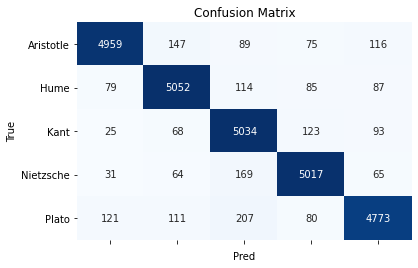

In [ ]:

# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### BI-LSTM: Kappa Score

In [ ]:

from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test_sorted,rounded_predictions))



0.9090390004357682


### BI-LSTM: Plotting Result to Compare Model Performance on Training & Validation Set

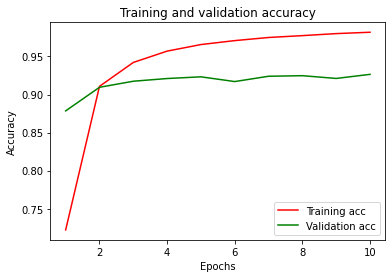

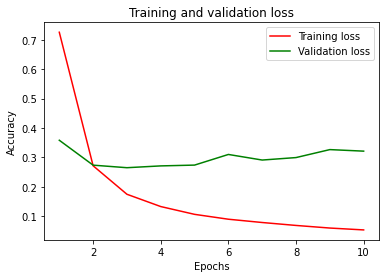

In [ ]:

# Verifying accuracy of training set versus validation set

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### BI-LSTM: Hyperparameter Tuning GRIDCV 

In [ ]:

optimize = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']

activators = ['relu','sigmoid','softmax','softplus','softsign','tanh','selu','elu','exponential']

batch_sizes = [47,128,256,500]

epoch_tests = [10,15,20,40]


# BI-LSTM: DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving Bi-LSTM model

In [ ]:
# bi_lstm_model1.save("bi-lstm_modelstrat.h5")
# load.model('/content/bi-lstm_model2.h5')

In [ ]:
# Importing the developed Bi-LSTM models

# from tensorflow import keras

# model = keras.models.load_model('/content/bi-lstm_model22.h5')

# GRU MODEL

In [ ]:

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,Flatten,MaxPooling1D,GRU
from keras.callbacks import EarlyStopping


## GRU MODEL ARCHITECTURE & TRAINING

In [ ]:

gru_model = Sequential()
gru_model.add(Embedding(vocab,emb_dim))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.8))
gru_model.add(Dense(5, activation = 'sigmoid'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 130)         5301530   
_________________________________________________________________
gru (GRU)                    (None, 128)               99840     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 5,402,015
Trainable params: 5,402,015
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

%%time
history = gru_model.fit(X_train, y_train,validation_split=0.2,
                        epochs=15, batch_size= 128 ,verbose=2,shuffle=True) # 256


Epoch 1/15
503/503 - 8s - loss: 0.7255 - accuracy: 0.7250 - val_loss: 0.3447 - val_accuracy: 0.8826
Epoch 2/15
503/503 - 6s - loss: 0.2590 - accuracy: 0.9200 - val_loss: 0.3032 - val_accuracy: 0.9047
Epoch 3/15
503/503 - 6s - loss: 0.1555 - accuracy: 0.9522 - val_loss: 0.3015 - val_accuracy: 0.9138
Epoch 4/15
503/503 - 6s - loss: 0.1140 - accuracy: 0.9657 - val_loss: 0.2998 - val_accuracy: 0.9157
Epoch 5/15
503/503 - 6s - loss: 0.0921 - accuracy: 0.9730 - val_loss: 0.3792 - val_accuracy: 0.9121
Epoch 6/15
503/503 - 6s - loss: 0.0819 - accuracy: 0.9752 - val_loss: 0.3320 - val_accuracy: 0.9218
Epoch 7/15
503/503 - 6s - loss: 0.0666 - accuracy: 0.9805 - val_loss: 0.3467 - val_accuracy: 0.9213
Epoch 8/15
503/503 - 6s - loss: 0.0519 - accuracy: 0.9849 - val_loss: 0.3968 - val_accuracy: 0.9171
Epoch 9/15
503/503 - 6s - loss: 0.0512 - accuracy: 0.9855 - val_loss: 0.3791 - val_accuracy: 0.9197
Epoch 10/15
503/503 - 6s - loss: 0.0413 - accuracy: 0.9879 - val_loss: 0.3796 - val_accuracy: 0.9245

# GRU: EVALUATION PHASE - PHILOSOPHERS TEXT

## GRU Model Evaluation 


## GRU: Accuracy

In [ ]:

# Determining Accuracy of the GRU model
accr = gru_model.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


837/837 [==============================] - 3s 3ms/step - loss: 0.5437 - accuracy: 0.9222
Test set
  Loss: 0.544
  Accuracy: 0.922


In [ ]:
predictions = gru_model.predict(X_test)

predictions = np.argmax(predictions,axis=-1)

predictions


y_test_sorted = np.argmax(y_test,axis=-1)

y_test_sorted

array([2, 1, 4, ..., 4, 2, 0])

### GRU: Confusion Matrix

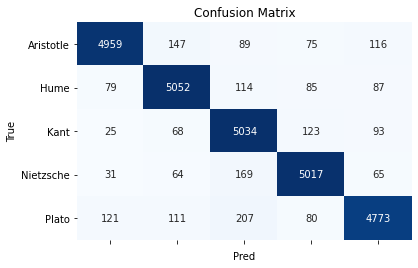

In [ ]:
cm = confusion_matrix(predictions,y_test_sorted)


# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


### GRU: Classification Report

In [ ]:
print(classification_report(predictions,y_test_sorted))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      5584
           1       0.90      0.95      0.92      5084
           2       0.91      0.92      0.92      5276
           3       0.94      0.92      0.93      5488
           4       0.92      0.91      0.91      5352

    accuracy                           0.92     26784
   macro avg       0.92      0.92      0.92     26784
weighted avg       0.92      0.92      0.92     26784



### Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(predictions,y_test_sorted))


0.902695430444109


### GRU: Plotting Result to Compare Model Performance on Training & Validation Set

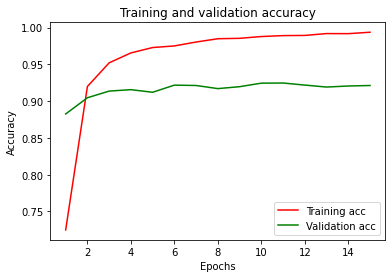

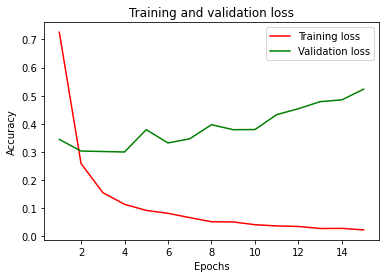

In [ ]:

# Verifying accuracy of training set versus validation set

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN MODEL


In [92]:
from tensorflow import keras 
from keras.preprocessing import sequence,text
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,SpatialDropout1D
from keras.callbacks import EarlyStopping


In [ ]:

# Initialising input variables 

sentences = df_n['sentence']

labels = df_n['label']


In [ ]:

max_words = 40000
max_len = 130
tokenize = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenize.fit_on_texts(sentences.values)
# Converting texts to sequences then into a word index
sequences = tokenize.texts_to_sequences(sentences.values)
word_index = tokenize.word_index
print(len(word_index))
# Pading texts to limit the word count
X = pad_sequences(sequences,maxlen=max_len)
y = keras.utils.to_categorical(labels.values,num_classes=5)


In [ ]:

# splitting training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.25, random_state=42)


In [ ]:
# Defining the number of epochs, embedding dimensions, batch size and vocab length required in the model
epochs = 50
emb_dim = 130
batch_size = 256
vocab = len(word_index) + 1


In [ ]:
# Checking that training and test set are the same input dims
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((80350, 130), (80350, 5), (26784, 130), (26784, 5))


## CNN MODEL ARCHITECTURE & TRAINING

In [ ]:
model_cnn = Sequential()
model_cnn.add((Embedding(vocab,emb_dim)))
# model_cnn.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model_cnn.add(GlobalMaxPooling1D())

model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))

model_cnn.add(Dense(5,activation='softmax'))


model_cnn.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy']) # RMSprop

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 130)         5301530   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 130)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          25024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [ ]:
%%time
history = model_cnn.fit(X_train, y_train,validation_split=0.2,epochs=15, batch_size=128,verbose=2,shuffle=True)



Epoch 1/15
503/503 - 16s - loss: 0.7689 - accuracy: 0.7113 - val_loss: 0.3439 - val_accuracy: 0.8829
Epoch 2/15
503/503 - 3s - loss: 0.2194 - accuracy: 0.9295 - val_loss: 0.2502 - val_accuracy: 0.9172
Epoch 3/15
503/503 - 3s - loss: 0.0928 - accuracy: 0.9716 - val_loss: 0.2376 - val_accuracy: 0.9270
Epoch 4/15
503/503 - 3s - loss: 0.0498 - accuracy: 0.9853 - val_loss: 0.2542 - val_accuracy: 0.9296
Epoch 5/15
503/503 - 3s - loss: 0.0283 - accuracy: 0.9917 - val_loss: 0.2759 - val_accuracy: 0.9287
Epoch 6/15
503/503 - 3s - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.2972 - val_accuracy: 0.9316
Epoch 7/15
503/503 - 3s - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.3218 - val_accuracy: 0.9279
Epoch 8/15
503/503 - 3s - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.3527 - val_accuracy: 0.9267
Epoch 9/15
503/503 - 3s - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.3718 - val_accuracy: 0.9266
Epoch 10/15
503/503 - 3s - loss: 0.0108 - accuracy: 0.9961 - val_loss: 0.3994 - val_accuracy: 0.923

# CNN: EVALUATION PHASE - PHILOSOPHERS TEXT

## CNN Model Evaluation 


### CNN: Accuracy

In [ ]:

accr = model_cnn.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


837/837 [==============================] - 2s 2ms/step - loss: 0.4732 - accuracy: 0.9284
Test set
  Loss: 0.473
  Accuracy: 0.928


### CNN: Predictions On Test Set

In [ ]:

# Bi-LSTM model predictions on test set 

predictions = model_cnn.predict(x= X_test, batch_size = 10, verbose = 2)


2679/2679 - 2s


In [ ]:
# Derive rounded predictions that will shift probability of class into actual prediction

rounded_predictions = np.argmax(predictions,axis=-1)

# Test to verify prediciton outputt after rounding

rounded_predictions

array([2, 1, 4, ..., 4, 2, 0])

## CNN: Classification Report

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
# Turning the rounded predictions into a dataframe 
labels_pred = pd.DataFrame(rounded_predictions)
labels_pred.shape
y_test_sorted = np.argmax(y_test,axis=-1)
                          
print(classification_report(y_test_sorted,rounded_predictions))


              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5386
           1       0.94      0.92      0.93      5417
           2       0.92      0.93      0.93      5343
           3       0.94      0.94      0.94      5346
           4       0.92      0.90      0.91      5292

    accuracy                           0.93     26784
   macro avg       0.93      0.93      0.93     26784
weighted avg       0.93      0.93      0.93     26784



### CNN: Confusion Matrix

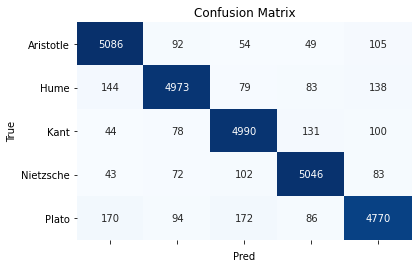

In [ ]:


# Generate Confusion Matrix 
cm = confusion_matrix(y_true=y_test_sorted,y_pred=rounded_predictions)


# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

### CNN: Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score


print(cohen_kappa_score(y_test_sorted,rounded_predictions))

0.9104393155392397


### CNN: Plotting Training & Validation Accuracy and Loss

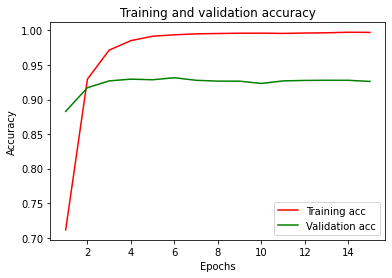

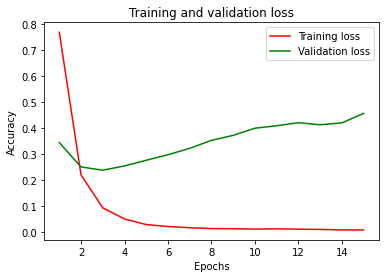

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN: DEPLOYMENT PHASE - PHILOSOPHERS TEXT
## Saving CNN model

In [ ]:
# model.save('CNN_noembed.h5')

# Word Embedding

## Glove Embeddings

In [51]:
sentences = df_stratified.sentence

labels = df_stratified.label

# Set max words for entire vocab and max len for padded sequences 
max_words = 45000 #40,000
max_len = 130

# Text pre-processing libraries 

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# y to categorical

y = keras.utils.to_categorical(labels)

# Instantiate tokenizer 
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# # create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(sentences)
# # generate the sequence of tokens
sent_seq = tokenizer.texts_to_sequences(sentences)
# xtest_seq = tokenizer.texts_to_sequences(X_test)

# # pad the sequences
sent_pad = sequence.pad_sequences(sent_seq, maxlen=max_len)
# xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index


# Split data into training and test set. 
X_train, X_test, y_train, y_test = train_test_split(sent_pad, y, test_size=0.20, random_state=42)



In [52]:

# Print an example of a training sentence 
print('text example:', sentences[1])
# Print an example of a the training sentence as a sequence
print('text sequence:', sent_seq[1])
# Print an example of a padded sequence 
print('text padded:', sent_pad[1])


text example: 1    that goes merely into our faculty of knowing t...
1    that goes merely into our faculty of knowing t...
1    that goes merely into our faculty of knowing t...
Name: sentence, dtype: object
text sequence: [1, 4181, 2, 1, 185, 343, 5, 59]
text padded: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1 4181    2    1
  185  343    5   59]


In [101]:
%%time 
import numpy as np
embedding_vec = {}

with open('/content/drive/MyDrive/data/glove.6B.100d.txt','r',encoding='utf-8') as file: # alternate for 50d to test different dimensional representations of the vectors that were tested.
  for row in file:
    values = row.split(" ")
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vec[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vec)}")  

Size of vocabulary in GloVe: 400000
CPU times: user 13.4 s, sys: 506 ms, total: 14 s
Wall time: 13.7 s


In [102]:
embedding_vec['fuck'], embedding_vec['you']

(array([ 0.098204 , -0.31437  ,  0.8189   , -1.1469   , -0.16131  ,
         0.14506  , -0.8431   ,  0.060309 ,  0.61314  ,  0.018681 ,
         0.74367  , -0.0067513,  0.63213  ,  0.52501  ,  0.03999  ,
         0.60981  , -0.11947  ,  0.26881  , -0.77633  ,  0.27557  ,
         0.9336   , -0.20553  , -0.45774  , -0.4199   , -0.41552  ,
         0.76869  , -0.32835  ,  0.24543  ,  0.59034  , -0.34562  ,
        -0.15989  , -0.33605  ,  0.17946  ,  0.86062  , -0.27782  ,
         0.18529  , -0.61097  ,  0.2871   ,  0.51686  , -0.83121  ,
         0.27443  ,  0.3185   , -0.13775  , -0.34251  , -1.0427   ,
         0.31568  , -0.24437  , -0.38877  , -0.27705  ,  0.32165  ,
        -0.5656   ,  1.0263   ,  0.11803  , -0.19347  , -1.3056   ,
        -0.36369  ,  0.47473  ,  0.55457  ,  0.037796 , -0.11567  ,
         0.82448  ,  0.66429  , -0.91183  , -0.55386  ,  0.54356  ,
         0.7421   ,  0.39296  , -0.67676  ,  0.14345  , -0.25598  ,
         0.046569 ,  0.37904  ,  0.56047  ,  0.2

In [104]:
import string
embedding_dimensions = 100 # or 50

if max_words is None:
  vocab_len = max_words
else:
  vocab_len = len(word_index) + 1
embedding_matrix = np.zeros((vocab_len,embedding_dimensions))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
  if idx < vocab_len:
    embedding_vector = embedding_vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[idx] = embedding_vector
    else:
      oov_count += 1
      oov_words.append(word)


In [105]:
print(f'Some out of vocabulary words: {oov_words[0:10]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')


Some out of vocabulary words: ['synthetical', 'purposiveness', 'cebes', 'supersensible', 'simmias', 'sanguineous', 'cleinias', 'cogitated', 'cognize', 'ftus']
11558 out of 40781 words were OOV.


In [ ]:
oov_words

In [107]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(85707, 130) (85707, 5) (21427, 130) (21427, 5)


In [108]:
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
         0.27062 ],
       [-0.1529  , -0.24279 ,  0.89837 , ..., -0.591   ,  1.0039  ,
         0.20664 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.48766 ,  0.10357 , -0.011503, ..., -0.59372 , -0.079446,
         0.66498 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

## GRU: GLOVE WORD EMBEDDING MODEL ARCHITECTURE AND TRAINING.

In [110]:

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,Flatten,MaxPooling1D,GRU
from keras.callbacks import EarlyStopping


In [112]:
gru_model = Sequential()

gru_model.add(Embedding(vocab_len, embedding_dimensions, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(5, activation = 'sigmoid'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         4078100   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 4,167,065
Trainable params: 88,965
Non-trainable params: 4,078,100
_________________________________________________________________
None


In [113]:
%%time

# epoch = 15
# history = gru_model.fit(X_train,y_train,epochs=epoch, verbose=2,validation_split=0.2,batch_size = 128,shuffle=True)


history = gru_model.fit(X_train, y_train, epochs=epoch, batch_size=128,validation_split=0.2
                    ,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)],shuffle=True)



Epoch 1/15
536/536 [==============================] - 8s 13ms/step - loss: 0.9452 - accuracy: 0.6450 - val_loss: 0.7344 - val_accuracy: 0.7256
Epoch 2/15
536/536 [==============================] - 6s 12ms/step - loss: 0.7053 - accuracy: 0.7420 - val_loss: 0.6333 - val_accuracy: 0.7647
Epoch 3/15
536/536 [==============================] - 6s 12ms/step - loss: 0.6024 - accuracy: 0.7795 - val_loss: 0.5644 - val_accuracy: 0.7928
Epoch 4/15
536/536 [==============================] - 6s 12ms/step - loss: 0.5375 - accuracy: 0.8061 - val_loss: 0.5036 - val_accuracy: 0.8176
Epoch 5/15
536/536 [==============================] - 6s 12ms/step - loss: 0.4759 - accuracy: 0.8300 - val_loss: 0.4702 - val_accuracy: 0.8327
Epoch 6/15
536/536 [==============================] - 6s 12ms/step - loss: 0.4267 - accuracy: 0.8493 - val_loss: 0.4401 - val_accuracy: 0.8459
Epoch 7/15
536/536 [==============================] - 6s 12ms/step - loss: 0.3927 - accuracy: 0.8621 - val_loss: 0.4259 - val_accuracy: 0.8504

# GRU: GLOVE EMBEDDING MODEL PERFORMANCE EVALUATION AND ACCURACY

In [114]:
gru_model.evaluate(X_test,y_test,verbose=2)

670/670 - 3s - loss: 0.3921 - accuracy: 0.8830


[0.3921356797218323, 0.8829514384269714]

In [115]:
predictions = gru_model.predict(X_test)

predictions = np.argmax(predictions,axis=-1)

predictions

# np.argmax(predictions,axis=-1)
recon_y_test = np.argmax(y_test,axis=-1)

recon_y_test

array([2, 1, 4, ..., 0, 0, 3])

### GRU: GLOVE WORD EMBEDDING model accuracy and kappa score 

In [97]:
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,classification_report
cm = confusion_matrix(predictions,recon_y_test)

print(accuracy_score(predictions,recon_y_test))

print(cohen_kappa_score(predictions,recon_y_test))


0.8854716012507584
0.8568384007613118


### GRU: GLOVE WORD EMBEDDING Model Classification Report 

In [98]:
print(classification_report(predictions,recon_y_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4383
           1       0.86      0.90      0.88      4107
           2       0.89      0.89      0.89      4294
           3       0.92      0.87      0.90      4514
           4       0.86      0.88      0.87      4129

    accuracy                           0.89     21427
   macro avg       0.89      0.89      0.89     21427
weighted avg       0.89      0.89      0.89     21427



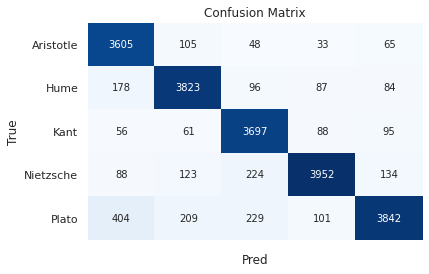

In [117]:

# Initialise class names 
classes = np.unique(philo_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(predictions, recon_y_test)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

### GRU: GLOVE WORD EMBEDDING Model Training and Validation Accuracy  

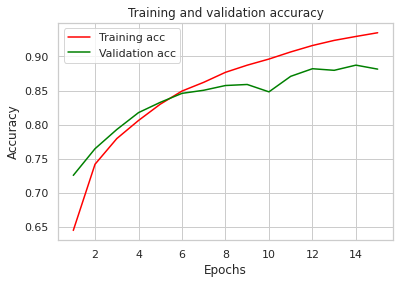

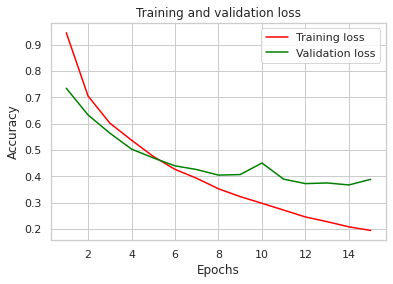

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Word2Vec Word Embedding

# Test Word Embedding


In [ ]:
# Establishing the number of max words to incorporate
from keras.preprocessing.text import Tokenizer
max_words = 40000

# Instatisiating the tokenizer on the setence level and not a character level 

tokenize = Tokenizer(num_words=max_words, char_level=False)

# Fitting the tokenzier

tokenize.fit_on_texts(X_train) # only fit on train

from collections import Counter


def unique_word_counter(sent):
  count = Counter()
  for i in sent.values:
    for word in i.split():
      count[word] +=1
  return count


text = df_n.sentence


counter = unique_word_counter(text)


len(counter)
counter
num_words = len(counter)
num_words
max_length = 100
max_length

In [ ]:
# Creating word_ index

from collections import Counter

# creating function

def unique_word_counter(sent):
  count = Counter()
  for i in sent.values:
    for word in i.split():
      count[word] +=1
  return count

# 

text = df_n.sentence


#
counter = unique_word_counter(text)




In [ ]:
counter

In [ ]:
num_words = len(counter)
num_words
max_length = 1000
max_length

In [ ]:
# # Different way of splitting dataset in training and test set 

train_size = int(df_n.shape[0]* 0.8)

train_sentences = df_n.sentence[:train_size]
train_label = df_n.label[:train_size]

test_sentences = df_n.sentence[train_size:]
test_label = df_n.label[train_size:]

## Splitting variables in X and y
# labels = df_n['label']
# print(test_label[0])
# # corpus =df_n['sentence']

y_train = keras.utils.to_categorical(train_label,num_classes=5)
y_test = keras.utils.to_categorical(test_label,num_classes=5)

print(y_test[0])

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
word_index = tokenizer.word_index


In [ ]:

word_index


In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
print(train_sequences[0])


print(train_sentences[0])



In [ ]:
# Pad Sequences to The Same Lenght 
max_length=30
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(train_sequences,maxlen= max_length,padding= 'post',truncating ='post')


In [ ]:
train_padded[0]

In [ ]:
print(df_n.sentence[0])
print(train_sequences[0])

In [ ]:
print(f"shape of train {train_padded.shape}")

print(f"shape of test {test_padded.shape}")

In [ ]:
decode(train_sequences[0])

In [ ]:
reverse_word_index = dict([value,key]for (key,value) in word_index.items())

reverse_word_index

In [ ]:
def decode(text):
  return " ".join([reverse_word_index.get(i,'?') for i in text])

In [ ]:
# Vectorize and pad test 
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,maxlen= max_length,padding= 'post',truncating ='post')